In [1]:
import sqlite3
from janome.tokenizer import Tokenizer

tokenizer = Tokenizer()
stop_words = ['・', '、', ')、', '(', '(-', ')【', ' ', '】', '-', '。', '）', '（', ')(']

def stems(text):
    if text == None:
        return []
    token_list = [token.surface for token in tokenizer.tokenize(text) if token.part_of_speech.count(u"数") == 0 and token.surface not in stop_words]
    return token_list

def stems_uniq(text):
    if text == None:
        return []
    token_list = [token.surface for token in tokenizer.tokenize(text) if token.part_of_speech.count(u"数") == 0 and token.surface not in stop_words]
    return set(token_list)

db_path = "/Users/thotta/git/ifinance/sample.db"
conn = sqlite3.connect(db_path)
cur = conn.cursor()
cur.execute("""SELECT stock_id, company_name, company_feature, 
business_description, business_category, small_business_category 
FROM company_profile;""")
f_map = {}
names = {}
for code, name, feature, desc, l_category, s_category in cur.fetchall():
    feature = '' if feature == None else feature
    desc = '' if desc == None else desc
    l_category = '' if l_category == None else l_category
    s_category = '' if s_category == None else s_category
    #features = ' '.join([desc])
    features = ' '.join([feature, desc, l_category, s_category])
    f_map[code] = features
    names[code] = name


In [11]:
# days日以前の直近の株価マップを返す
def get_past(cursor, days):
    cur.execute("""
    SELECT stock_id, market_cap 
    FROM daily_stock_price 
    WHERE o_date = (select max(o_date) from daily_stock_price where o_date < date('now', '-%d days'))
    """ % days)
    return cur.fetchall()

add_days = 20
mcap000 = {code:mcap for (code, mcap) in get_past(cur, 0 + add_days)}
mcap030 = {code:mcap for (code, mcap) in get_past(cur, 30 + add_days)}
mcap060 = {code:mcap for (code, mcap) in get_past(cur, 60 + add_days)}
mcap090 = {code:mcap for (code, mcap) in get_past(cur, 90 + add_days)}
mcap120 = {code:mcap for (code, mcap) in get_past(cur, 120 + add_days)}

In [12]:
# Validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer(analyzer=stems, ngram_range=(1, 1))
count_vec = CountVectorizer(analyzer=stems_uniq, ngram_range=(1, 1))

v_map = {}
t_map = {}
for key in mcap030:
    if key in mcap120 and mcap120[key] != 0 and key in mcap000 and mcap030[key] != 0:
        v_map[key] = float(mcap030[key]) / mcap120[key] - 1.0
        t_map[key] = float(mcap000[key]) / mcap030[key] - 1.0

v = []
f_list = []
name_list = []
t = []
for key in v_map:
    if key in f_map and len(f_map[key]) != 0 and key in names:
        v.append(v_map[key])
        t.append(t_map[key])
        f_list.append(f_map[key])
        name_list.append(names[key])
X_tfidf = vectorizer.fit_transform(f_list)
#X_tfidf = count_vec.fit_transform(f_list)

train_num:  3300
test_num:  366
alpha_list:  [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 204.8]


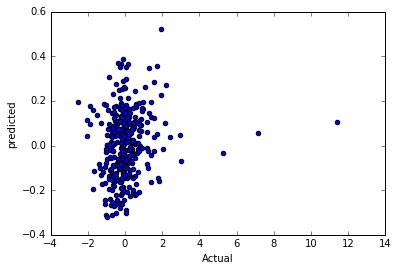

mse 1.10279602647


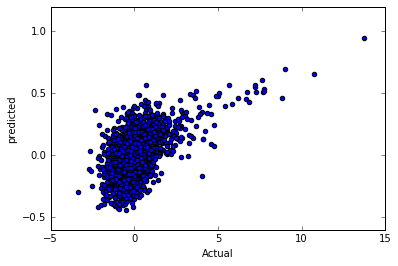

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.cross_validation import train_test_split
import numpy as np

v = np.array(v)
v_mean = v.mean()
v = (v - v.mean()) / v.std()
t = np.array(t)
t_mean = t.mean()
t = (t - t.mean()) / t.std()
name_list = np.array(name_list)
test_num = int(len(v) * 0.1)
np.random.seed(9)
perm = np.random.permutation(len(v))
p = list(perm)
#X_train, X_test, y_train, y_test = train_test_split(X_tfidf, v, test_size=0.1, random_state=1)
i = 4
train_perm = p[:test_num*i] + p[test_num*(i+1):]
test_perm = p[test_num*i : test_num*(i+1)]
print("train_num: ", len(train_perm))
print("test_num: ", len(test_perm))
X_train = X_tfidf[train_perm]
y_train = v[train_perm]
t_train = t[train_perm]
name_train = name_list[train_perm]

X_test = X_tfidf[test_perm]
y_test = v[test_perm]
t_test = t[test_perm]
name_test = name_list[test_perm]
#X_train, X_test, y_train, y_test = train_test_split(X_count, v, test_size=0.1, random_state=1)
alpha_list =  [0.1 * pow(2, i) for i in range(12)]
print("alpha_list: ", alpha_list)
slr = RidgeCV(alphas = alpha_list)
#slr = Ridge(alpha=5)
slr.fit(X_train, y_train)

y_train_pred = slr.predict(X_train)
y_pred = slr.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.show()

print("mse", mse(y_test, y_pred))

plt.scatter(y_train, y_train_pred)
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.show()

In [14]:
def accuracy(y_test, y_pred):
    t = 0.0
    f = 0.0
    for yi, yi_ in zip(y_test, y_pred):
        if(yi * yi_ > 0.0):
            t += 1.0
        else:
            f += 1.0
    return t/(t+f)

def average_ratio(y_test, y_pred):
    positive_ratio = 0.0
    negative_ratio = 0.0
    for yi, yi_ in zip(y_test, y_pred):
        if yi_ > 0.0:
            positive_ratio += yi / len(y_test)
        if yi_ < -0.0:
            negative_ratio += yi / len(y_test)
    return positive_ratio, negative_ratio
    

print("accuracy", accuracy(y_test, y_pred))
print("alpha", slr.alpha_)
print("positive, negative=", average_ratio(y_test, y_pred))

accuracy 0.5737704918032787
alpha 12.8
positive, negative= (0.076196685822915028, -0.039685131433232407)


In [15]:
coef_map = {term:coef for term, coef in zip(vectorizer.get_feature_names(), slr.coef_)}
print('=== 上位coef ===')
for c_tup in sorted(coef_map.items(), key=lambda x:x[1], reverse=True)[:20]:
    print(c_tup)
    
print('\n=== 下位coef ===')
for c_tup in sorted(coef_map.items(), key=lambda x:x[1], reverse=False)[:20]:
    print(c_tup)

=== 上位coef ===
('マーケティング', 0.5092496137639837)
('支援', 0.41715793836640841)
('アクセサリー', 0.34973228471438922)
('デザイン', 0.34198292620165782)
('タブレット', 0.33925027768609539)
('ＥＣ', 0.33572696057325035)
('雑貨', 0.33474871134690981)
('アミューズメント', 0.32459697256631531)
('開発', 0.31522795698927775)
('化', 0.31216477606324927)
('型', 0.31152527066139191)
('医薬品', 0.30603597717721542)
('医療', 0.29609786400522686)
('オフショア', 0.29233451382431042)
('特', 0.28815374754212042)
('装置', 0.28079835634228772)
('コマース', 0.27351959640874901)
('コンテンツ', 0.27208984305325012)
('流動', 0.27009566252769807)
('単独', 0.2651960012938066)

=== 下位coef ===
('証券', -0.44699224947213989)
('自動車', -0.37349825608796772)
('機器', -0.34571671284247729)
('部品', -0.27963813784754743)
('海外', -0.26279808912768099)
('不動産', -0.26046762145559643)
('金融', -0.25889536658810935)
('機械', -0.25342137229592532)
('収益', -0.24319518656126624)
('機', -0.23884222040874986)
('で', -0.21958539032749108)
('タイヤ', -0.21653277937959586)
('電気', -0.20594030570291932)
('百貨店',

In [16]:
print("v_mean", v_mean)
print("t_mean", t_mean)

v_mean -0.0466852614823
t_mean 0.0473131462399


In [17]:
ratio = {name:(y_, y, y_-y, y + y_, t) for name, y, y_, t in zip(name_test, y_test, y_pred, t_test) if y_ - y < 1.0 and y_ - y > -1.0}
#ratio = {name:y_ - y for name, y, y_ in zip(name_train, y_train, y_train_pred) if y_ > 0.0}
sort_index = 2
sort_num = int(len(ratio) / 2)
#sort_num = 10
print("=== 上位 ===")
joui = 0.0
joui_ratio = 0.0
for tup in sorted(ratio.items(), key=lambda x:x[1][sort_index], reverse=True)[:sort_num]:
    joui += tup[1][4] / sort_num
    if tup[1][4] > 0.0:
        joui_ratio += 1.0 / sort_num
    #print(tup[0], "sort=", tup[1][sort_index], "lift=", tup[1][4])

print("\n=== 下位 ===")
kai = 0.0
kai_ratio = 0.0
for tup in sorted(ratio.items(), key=lambda x:x[1][sort_index], reverse=False)[:sort_num]:
    kai += tup[1][4] / sort_num
    if tup[1][4] < 0.0:
        kai_ratio += 1.0 / sort_num
    #print(tup[0], "sort=", tup[1][sort_index], "lift=", tup[1][4])
    
print("\n上位", joui, joui_ratio)
print("下位", kai, kai_ratio)

=== 上位 ===

=== 下位 ===

上位 0.189352204654 0.5095541401273885
下位 0.00868538917157 0.5159235668789809


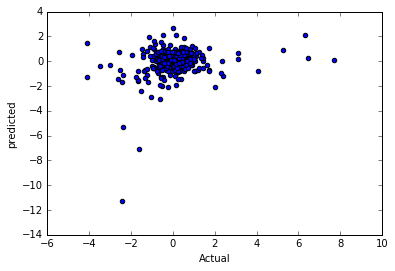

accuracy 0.5218579234972678
positive, negative= (0.08984767679998186, -0.081665753217636097)


In [18]:
score = y_pred - y_test
plt.scatter(t_test, score)
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.show()
print("accuracy", accuracy(t_test, score))
print("positive, negative=", average_ratio(t_test, score))

In [19]:
len(ratio)

314